In [14]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#Données dans un dataframe
df_real = pd.read_csv("director_avg.csv", sep=";", low_memory=False)
#on enlève la colonne inutile
df_real.drop('movie_nb_inclnodate', axis=1, inplace=True)
#pour info
print(df_real.columns.values)

['director_name' 'movie_nb' 'min_date' 'max_date' 'career_middle_date'
 'avg_time' 'id' 'vote_count' 'release_date2' 'Drama' 'Crime' 'Action'
 'Documentary' 'Adventure' 'Animation' 'Comedy' 'Mystery' 'Horror'
 'Western' 'Science Fiction' 'Thriller' 'Romance' 'Fantasy' 'War' 'Family'
 'Music' 'History' 'TV Movie' 'Foreign' 'en' 'de' 'fr' 'es' 'pt' 'ja' 'it'
 'zh' 'sv' 'da' 'other']


In [25]:
#df_tr = df_real[0:10000]
df_tr = df_real
#liste des noms de réals en numpy array
director_names = df_tr['director_name'].values
#Exclusion des noms de réals (non numériques) pour le travail de clustering
df_tr2 = df_tr.iloc[:,1:]
#convert to numpy array
df_tr2 = df_tr2.values.astype(int)
#pour info
print(df_tr2[0:15])

[[      4    1994    2002    1998       2  997150       0    7986       0
        0       1       0       0       0       1       0       0       0
        0       0       1       0       0       0       0       0       0
        0       4       0       0       0       0       0       0       0
        0       0       0]
 [      1    1986    1986    1986       2   64315       0    1986       1
        0       0       0       0       0       1       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       1]
 [      5    1985    2005    1995       4 1508480       1    9973       3
        0       0       0       0       0       0       0       0       0
        0       0       1       1       0       0       0       0       0
        0       1       0       0       0       0       0       0       3
        0       0       1]
 [      3    2005    2008    20

In [26]:
#méthode de normalisation choisie sans réfléchir, à revoir
scaler = StandardScaler()
#On cherche 10 clusters
model = KMeans(n_clusters=10)
#On rassemble tout pour aller plus vite
pipeline = make_pipeline(scaler,model)
#on fitte les modèles aux données et on les transforme
labels = pipeline.fit_predict(df_tr2)

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


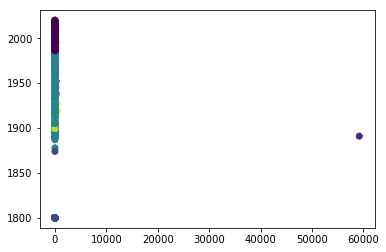

In [37]:
#on trace le graphe pour deux features, en espérant mettre en évidence les cluster (indiqués par des couleurs différentes). Pour l'instant, seulement des graphes "plats", donc la normalisationn'est sans doute pas bonne.
#Features choisies ici: movie_nb en abscisse, min_date en ordonnée
xs = df_tr2[:,0]
ys = df_tr2[:,1]
plt.scatter(xs,ys,c=labels)
plt.show()

In [21]:
#création de dataframe avec les labels de clusters et les noms de réals
df_f = pd.DataFrame({'labels':labels,'Dir_names':director_names})
#retourne un tableau avec les 10 catégories en row, les réalisateurs en colonnes, avec valeur 1 pour la catégorie à laquelle ils appartiennent. On peut en tirer les gorupes de réals mais je n'ai plus le temps.
ct = pd.crosstab(df_f['labels'],df_f['Dir_names'])
print(ct)

Dir_names  \tCheung Chi-Sing  \tRaymond Fung Sai-Hung   \tHuang Jian-Zhong  \
labels                                                                       
0                          0                        0                    0   
1                          1                        1                    0   
2                          0                        0                    0   
3                          0                        0                    0   
4                          0                        0                    0   
5                          0                        0                    0   
6                          0                        0                    0   
7                          0                        0                    1   
8                          0                        0                    0   
9                          0                        0                    0   

Dir_names   \tZhang Jing      Faris Kermani    Anna van Keimpem